## Dimensionality Reduction on Single-Cell BiTE Screen Profiles

In [1]:
import javabridge
import bioformats as bf
import skimage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import os
import re
import sys
import h5py

javabridge.start_vm(class_path=bf.JARS)

In [2]:
def load_bite(platedir, wells, annot):
    imgdf = []
    for w in wells:
        if os.path.isfile(os.path.join(platedir, w+'.csv')):
            df = pd.read_csv(os.path.join(platedir, w+'.csv'))
            df['well'] = w
            imgdf.append(df)
    imgdf = pd.concat(imgdf).reset_index(drop=True)
    labels = imgdf[['well']]
    imgdf = imgdf.drop(['well'], axis=1) 
    labels = pd.merge(labels, annot, on='well')
    return imgdf, labels

In [3]:
path = '../data/BiTE-profiles/'
plates = ['BiTE-Tag1',
          'BiTE-Tag2',
          'BiTE-Tag12']

In [4]:
# load plate annotation
annot_df = pd.read_csv('../data/BiTE/bite_annot.csv')
annot_df = annot_df[np.isin(annot_df['plate'], plates)]

In [5]:
annot_df.head()

,plate,well,PatientID,BiTE,BiTE.Conc,Drug,Drug.Conc,comb
0,BiTE-Tag1,r02c02,18LN0077,DMSO,0.0,DMSO,0.0,DMSO
1,BiTE-Tag1,r02c04,18LN0077,CD19,100.0,DMSO,0.0,CD19_100
2,BiTE-Tag1,r02c06,18LN0077,DMSO,0.0,I-BET-762,1.0,I-BET-762_1
3,BiTE-Tag1,r02c08,18LN0077,CD19,1.0,I-BET-762,1.0,CD19_1_I-BET-762_1
4,BiTE-Tag1,r02c10,18LN0077,CD20,1.0,I-BET-762,1.0,CD20_1_I-BET-762_1


In [6]:
dmso = annot_df[annot_df['BiTE']=='DMSO']
dmso = dmso[dmso['Drug']=='DMSO'].reset_index(drop=True)

In [7]:
dmso.head()

,plate,well,PatientID,BiTE,BiTE.Conc,Drug,Drug.Conc,comb
0,BiTE-Tag1,r02c02,18LN0077,DMSO,0.0,DMSO,0.0,DMSO
1,BiTE-Tag1,r02c24,18LN0098,DMSO,0.0,DMSO,0.0,DMSO
2,BiTE-Tag1,r08c12,18LN0077,DMSO,0.0,DMSO,0.0,DMSO
3,BiTE-Tag1,r08c14,18LN0098,DMSO,0.0,DMSO,0.0,DMSO
4,BiTE-Tag1,r10c12,18LN0077,DMSO,0.0,DMSO,0.0,DMSO


In [8]:
plate = plates[0]

platedir = os.path.join(path, plate)
annot = dmso[dmso['plate']==plate]
wells = annot['well'].values

ctrl_df, ctrl_annot = load_bite(platedir=platedir,
                                wells=wells,
                                annot=annot)

<AxesSubplot:xlabel='ch-Calcein-area'>

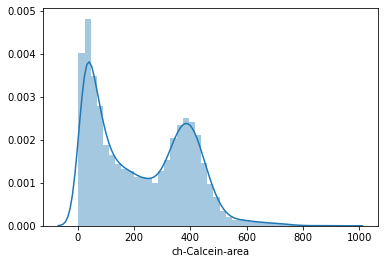

In [9]:
sn.distplot(ctrl_df['ch-Calcein-area'])

In [10]:
# in this case we have only one patient
ctrl_annot['PatientID'].unique()

array(['18LN0077', '18LN0098'], dtype=object)

In [11]:
thresh = 300
viab = (ctrl_df['ch-Calcein-area'] > thresh).values

In [12]:
ctrl_df = ctrl_df[viab]
ctrl_annot = ctrl_annot[viab]

In [13]:
from bioimg.singlecell import select_features, preprocess_data
sel = ['ch-Calcein-area', 
       'ch-Calcein-mean_intensity',
       'ch-Calcein-solidity',
       'ch-Calcein-extent',
       'ch-Calcein-filled_area',
       'ch-PE-mean_intensity',
       'ch-PE-area',
       'ch-PE-solidity',
       'ch-PE-extent',
       'ch-PE-filled_area',
       'ch-APC-area',
       'ch-APC-mean_intensity',
       'ch-APC-solidity',
       'ch-APC-extent',
       'ch-APC-filled_area',
       'ch-Hoechst-area',
       'ch-Hoechst-mean_intensity',
       'ch-Hoechst-solidity',
       'ch-Hoechst-extent',
       'ch-Hoechst-filled_area']
imgdf = preprocess_data(df=ctrl_df, sel=sel, glog=True)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [14]:
from sklearn.preprocessing import StandardScaler
from bioimg.singlecell import scale_data, check_data
'''scaler = StandardScaler().fit(X=imgdf)
imgdf_scaled = scale_data(imgdf, scaler=scaler)'''

sample_ids = ctrl_annot['PatientID'].unique()
imgdf_scaled = []
ctrl_both = []
for samp in sample_ids:
    ctrl_s = ctrl_df[ctrl_annot['PatientID']==samp]
    imgdf = preprocess_data(df=ctrl_s, sel=sel, glog=True)
    scaler = StandardScaler().fit(X=imgdf)
    imgdf_samp = scale_data(imgdf, scaler=scaler)
    imgdf_scaled.append(imgdf_samp)
    ctrl_both.append(ctrl_annot[ctrl_annot['PatientID']==samp])

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0
Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [15]:
imgdf_scaled = pd.concat(imgdf_scaled).reset_index(drop=True)
ctrl_both = pd.concat(ctrl_both).reset_index(drop=True)

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=8)
pcs = pca.fit_transform(imgdf_scaled)
X_tsne = TSNE(n_components=2, random_state=21, perplexity=50).fit_transform(pcs)

In [17]:
'''plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=3)
sn.despine()
plt.axhline(y=1, color='black', linestyle=':')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')'''

"plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=3)\nsn.despine()\nplt.axhline(y=1, color='black', linestyle=':')\nplt.xlabel('Number of principal components')\nplt.ylabel('Cumulative explained variance')"

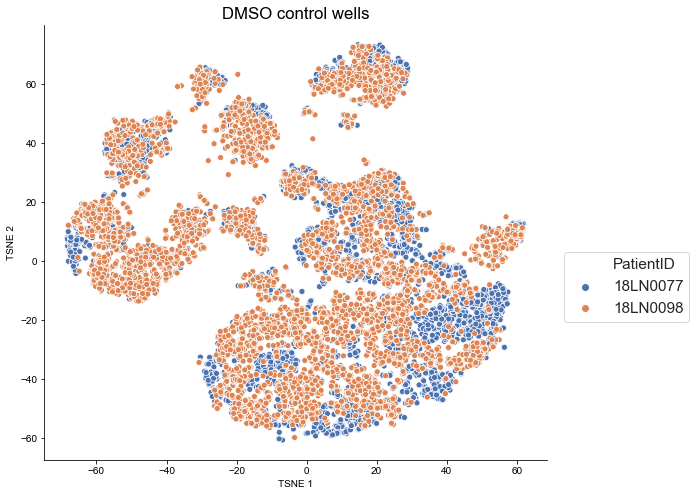

In [18]:
from bioimg.singlecell import plot_dimred
X_df = pd.concat([pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']), ctrl_both], axis=1)

plot_dimred(X_df,
            hue='PatientID',
            title='DMSO control wells')
plt.legend(loc='lower right',
           bbox_to_anchor=(1.3,0.3))

In [19]:
X_df = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
feat_subset = ['ch-Calcein-area', 
               'ch-Calcein-mean_intensity',
               'ch-PE-mean_intensity',
               'ch-APC-mean_intensity',
               'ch-PE-area',
               'ch-APC-area',
               'ch-PE-solidity',
               'ch-APC-solidity',
               'ch-Hoechst-area']
Xfeat = imgdf_scaled.loc[:,feat_subset]
X_df = pd.concat([X_df, Xfeat], axis=1)

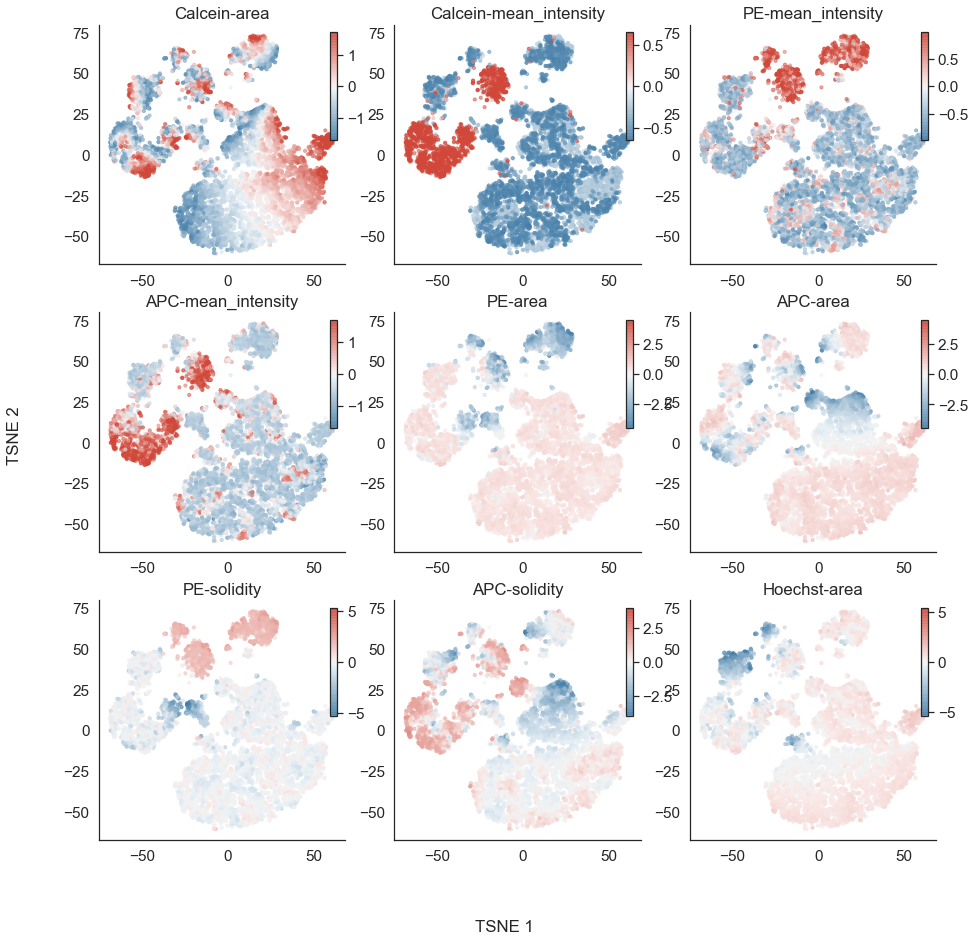

In [20]:
from bioimg.singlecell import facet_dimred
facet_dimred(X_df, 
             feat_subset=feat_subset,
            nrows=3, ncols=3)

Try a different plate with 2 biological samples:

In [21]:
plate = plates[1]

platedir = os.path.join(path, plate)
annot = dmso[dmso['plate']==plate]
wells = annot['well'].values

ctrl_df, ctrl_annot = load_bite(platedir=platedir,
                                wells=wells,
                                annot=annot)

thresh = 300
viab = (ctrl_df['ch-Calcein-area'] > thresh).values

In [22]:
ctrl_df = ctrl_df[viab].reset_index(drop=True)
ctrl_annot = ctrl_annot[viab].reset_index(drop=True)

In [23]:
sample_ids = ctrl_annot['PatientID'].unique()
imgdf_scaled = []
ctrl_both = []
for samp in sample_ids:
    ctrl_s = ctrl_df[ctrl_annot['PatientID']==samp]
    imgdf = preprocess_data(df=ctrl_s, sel=sel, glog=True)
    scaler = StandardScaler().fit(X=imgdf)
    imgdf_samp = scale_data(imgdf, scaler=scaler)
    imgdf_scaled.append(imgdf_samp)
    ctrl_both.append(ctrl_annot[ctrl_annot['PatientID']==samp])

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0
Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [24]:
imgdf_scaled = pd.concat(imgdf_scaled).reset_index(drop=True)
ctrl_both = pd.concat(ctrl_both).reset_index(drop=True)

In [25]:
'''imgdf = preprocess_data(df=ctrl_df, sel=sel, glog=True)
scaler = StandardScaler().fit(X=imgdf)
imgdf_scaled = scale_data(imgdf, scaler=scaler)'''

'imgdf = preprocess_data(df=ctrl_df, sel=sel, glog=True)\nscaler = StandardScaler().fit(X=imgdf)\nimgdf_scaled = scale_data(imgdf, scaler=scaler)'

In [26]:
pca = PCA(n_components=8)
pcs = pca.fit_transform(imgdf_scaled)
X_tsne = TSNE(n_components=2, random_state=21, perplexity=50).fit_transform(pcs)

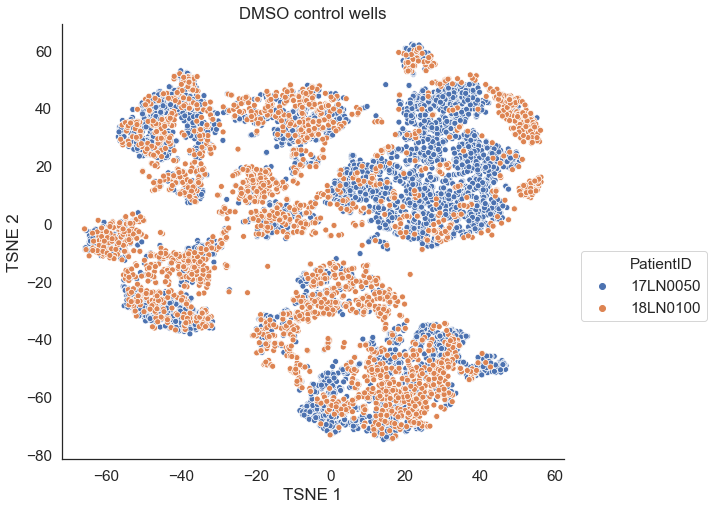

In [27]:
X_df = pd.concat([pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']), ctrl_both], axis=1)

plot_dimred(X_df,
            hue='PatientID',
            title='DMSO control wells')
plt.legend(loc='lower right',
           bbox_to_anchor=(1.3,0.3))

In [28]:
X_df = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
feat_subset = ['ch-Calcein-area', 
               'ch-Calcein-mean_intensity',
               'ch-PE-mean_intensity',
               'ch-APC-mean_intensity',
               'ch-PE-area',
               'ch-APC-area',
               'ch-PE-solidity',
               'ch-APC-solidity',
               'ch-Hoechst-area']
Xfeat = imgdf_scaled.loc[:,feat_subset]
X_df = pd.concat([X_df, Xfeat], axis=1)

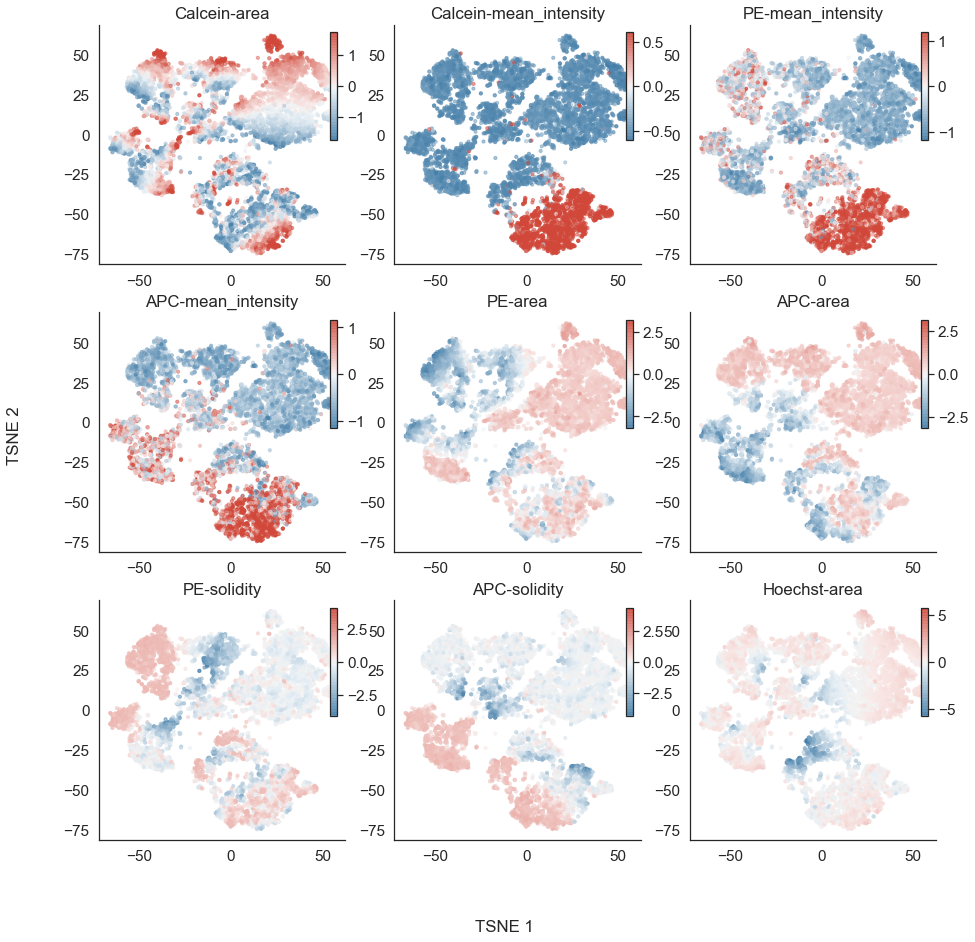

In [29]:
from bioimg.singlecell import facet_dimred
facet_dimred(X_df, 
             feat_subset=feat_subset,
            nrows=3, ncols=3)